In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

### Pipeline Steps:

1. Calibrate the incoming image to correct for camera distortion
1. Distort to bird's eye view
    1. Find the lane lines
    1. Find the closest and farthest points on each lane line
    1. Transform those points to be rectangular(?)
1. Use Sobel operator to detect roughly vertical lines?

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb
from pathlib import Path

## Camera Calibration Step

In [3]:
PATH = Path('./camera_cal/')
n_cols = 9
n_rows = 6
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((n_cols*n_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)

In [4]:
for filename in list(PATH.iterdir()):
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (n_cols, n_rows), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (n_cols, n_rows), corners, ret)
    else: 
        print('Unable to calibrate', filename)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Unable to calibrate camera_cal\calibration1.jpg
Unable to calibrate camera_cal\calibration4.jpg
Unable to calibrate camera_cal\calibration5.jpg


Let's grab a warped looking file and run it through the calibration step...

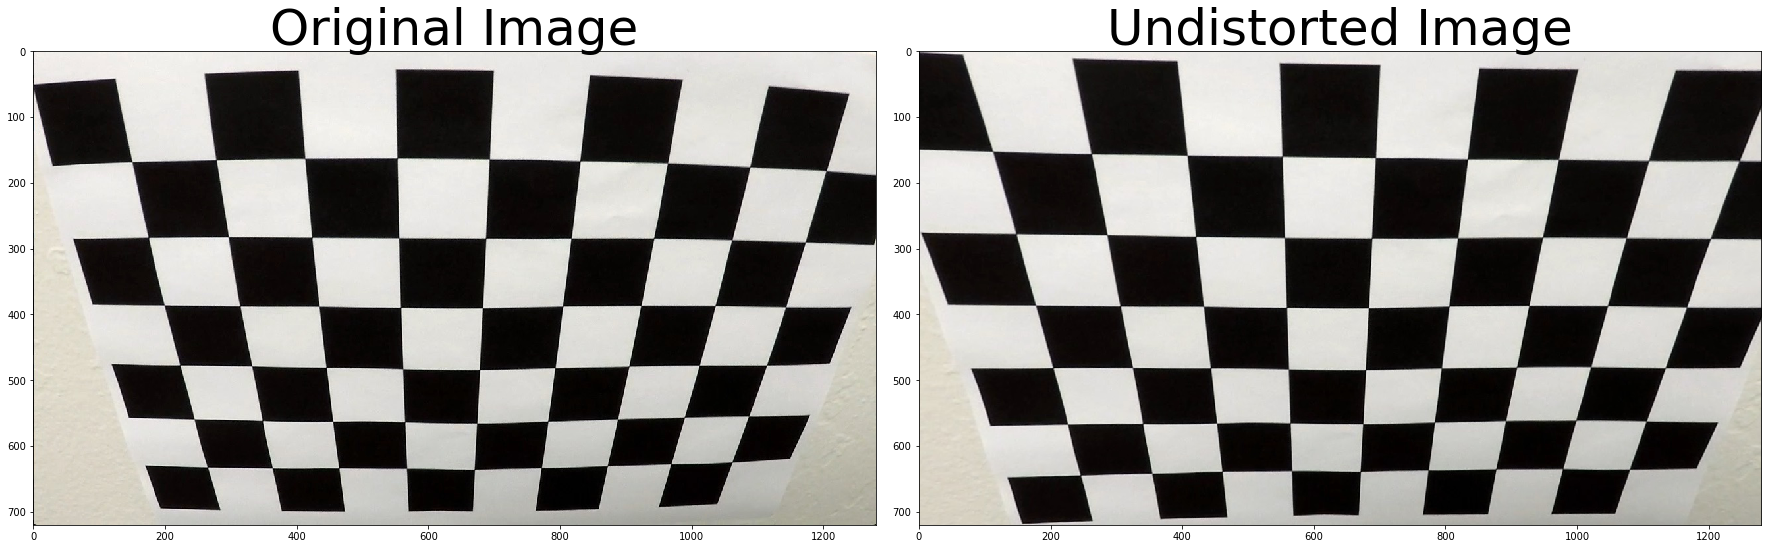

In [5]:
filename = list(PATH.iterdir())[11]
img = plt.imread(filename)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def calibrate_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Let's take a look at some of the test images

This code is very handy for displaying a few images easily

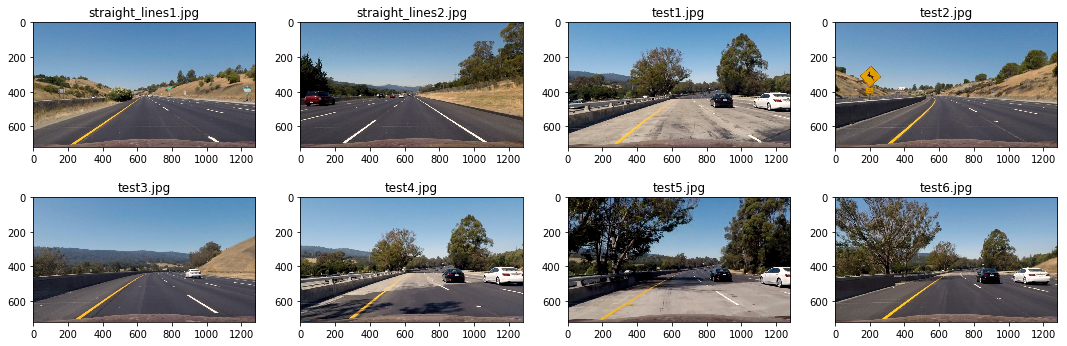

In [189]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 4

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    img = calibrate_image(img)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    ax.imshow(img)
    ax.set_title(str(filename).split('\\')[-1])
plt.tight_layout()

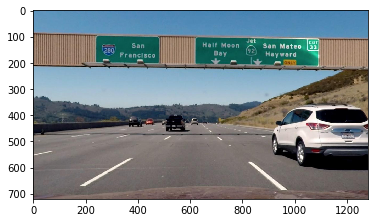

In [8]:
PATH = Path('./test_images/')
image = mpimg.imread(str(PATH/'test7.png'))
image = calibrate_image(image)
plt.imshow(image)

# Sobel Gradient

In [28]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
       sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
       sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    max_sobel = np.max(abs_sobel)
    scaled_sobel = abs_sobel * 255 / max_sobel
    scaled_sobel = scaled_sobel.astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
#     print(np.max(scaled_sobel))
    return s_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # x gradient
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # y gradient

    # Calculate the magnitude 
    sum_sq = np.sqrt(sobel_x**2 + sobel_y**2)
    max_sobel = np.max(sum_sq)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = sum_sq * 255 / max_sobel
    scaled_sobel = scaled_sobel.astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    post_threshold = np.zeros_like(scaled_sobel)
    post_threshold[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return post_threshold

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # x gradient
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # y gradient
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use arctan2 to calculate the direction of the gradient 
    atan = np.arctan2(abs_sobel_y, abs_sobel_x) # Element-wise arc tangent of y/x
    # Create a binary mask where direction thresholds are met
    post_threshold = np.zeros_like(atan)
    post_threshold[(atan >= thresh[0]) & (atan <= thresh[1])] = 1
    return post_threshold

In [182]:
### Parameters to tune
ksize = 7 # Choose a larger odd number to smooth gradient measurements
thresh = (50, 255)
mag_thresh = (50, 255)
dir_thresh = (0.8, 1.2)

def gradient_sobel(img):
    ''' Takes an RGB image and computes several gradients to remove non-lane pixels
    '''
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_threshold(img, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

## Let's test the functions we've developed:

It's clearly missing some areas (especially yellow lines), but not bad!

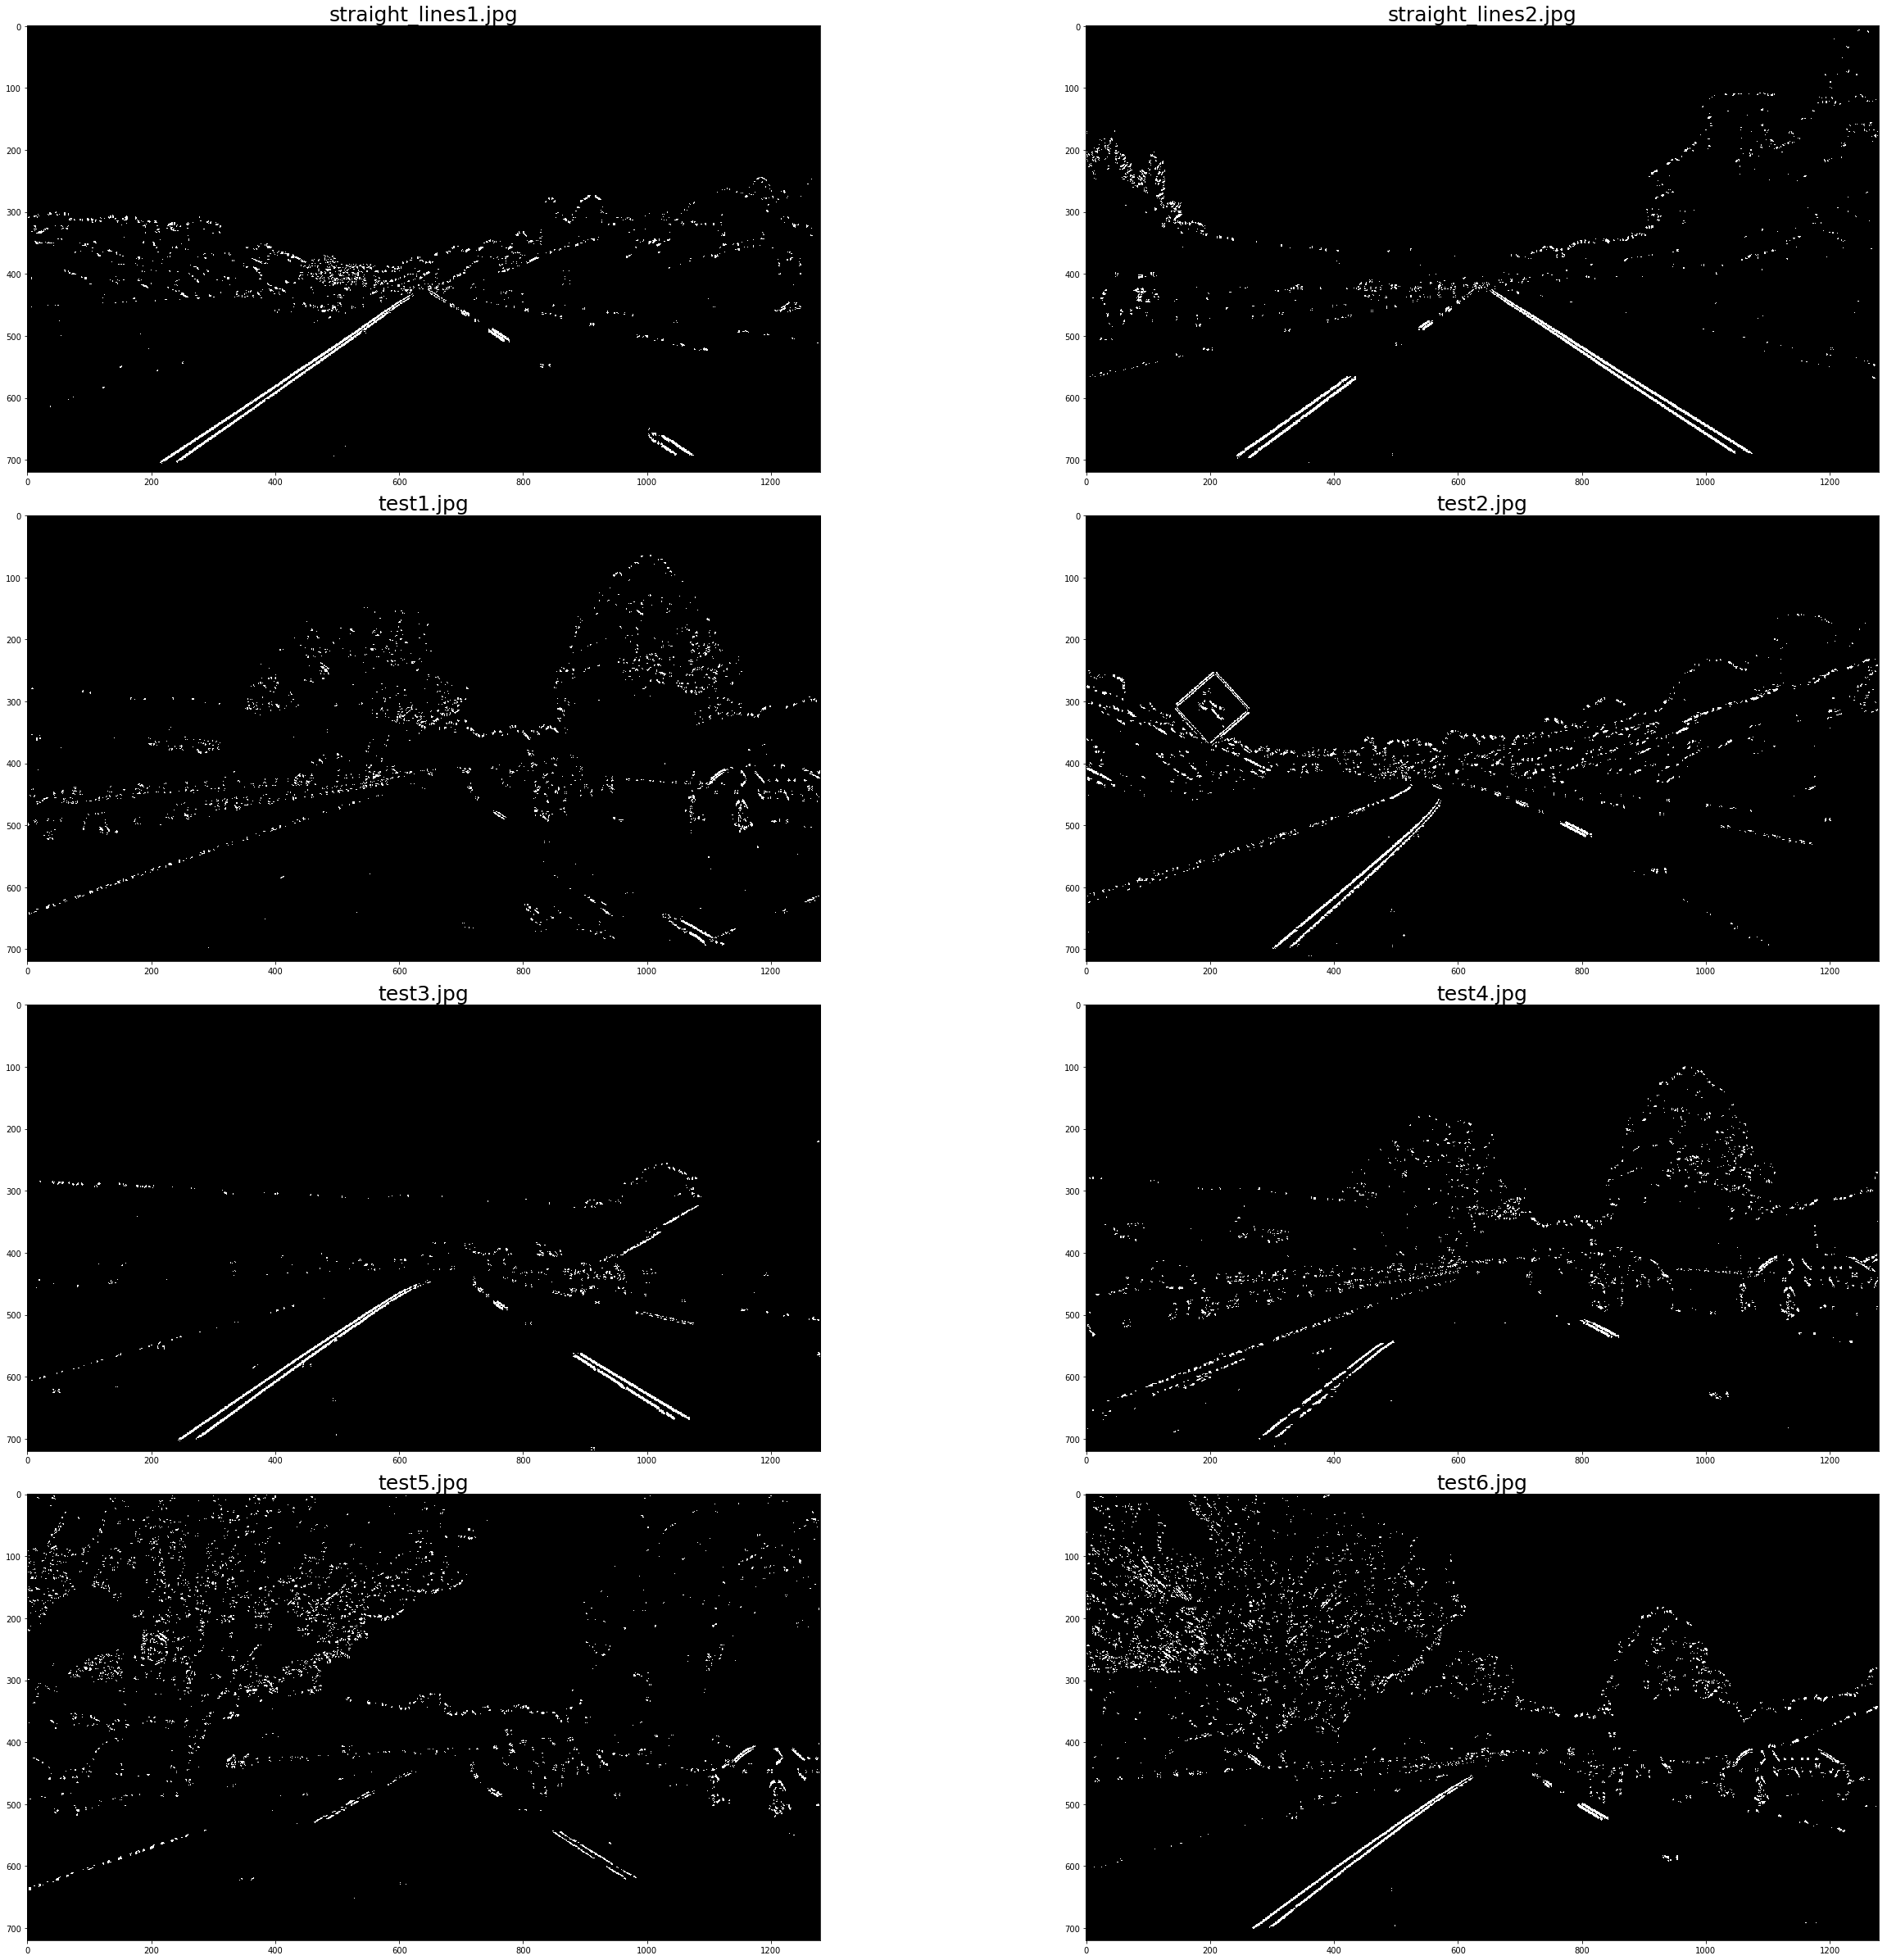

In [156]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
image_width = 80/row_len
image = None

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = gradient_sobel(img)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# HSL / HSV Color Space

In [257]:
### Parameters to tune
s_min = 200
s_max = 255
v_min = 215
v_max = 255

def color_transform(img):
    ''' Takes an RGB image, converts it to HSV and HLS, and uses thresholds to remove non-lane pixels
    '''
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_min) & (s_channel < s_max)] = 1
    
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_min) & (v_channel < v_max)] = 1
    
    out = np.zeros_like(s_channel)
    out[(s_binary == 1) | (v_binary == 1)] = 1
    return out

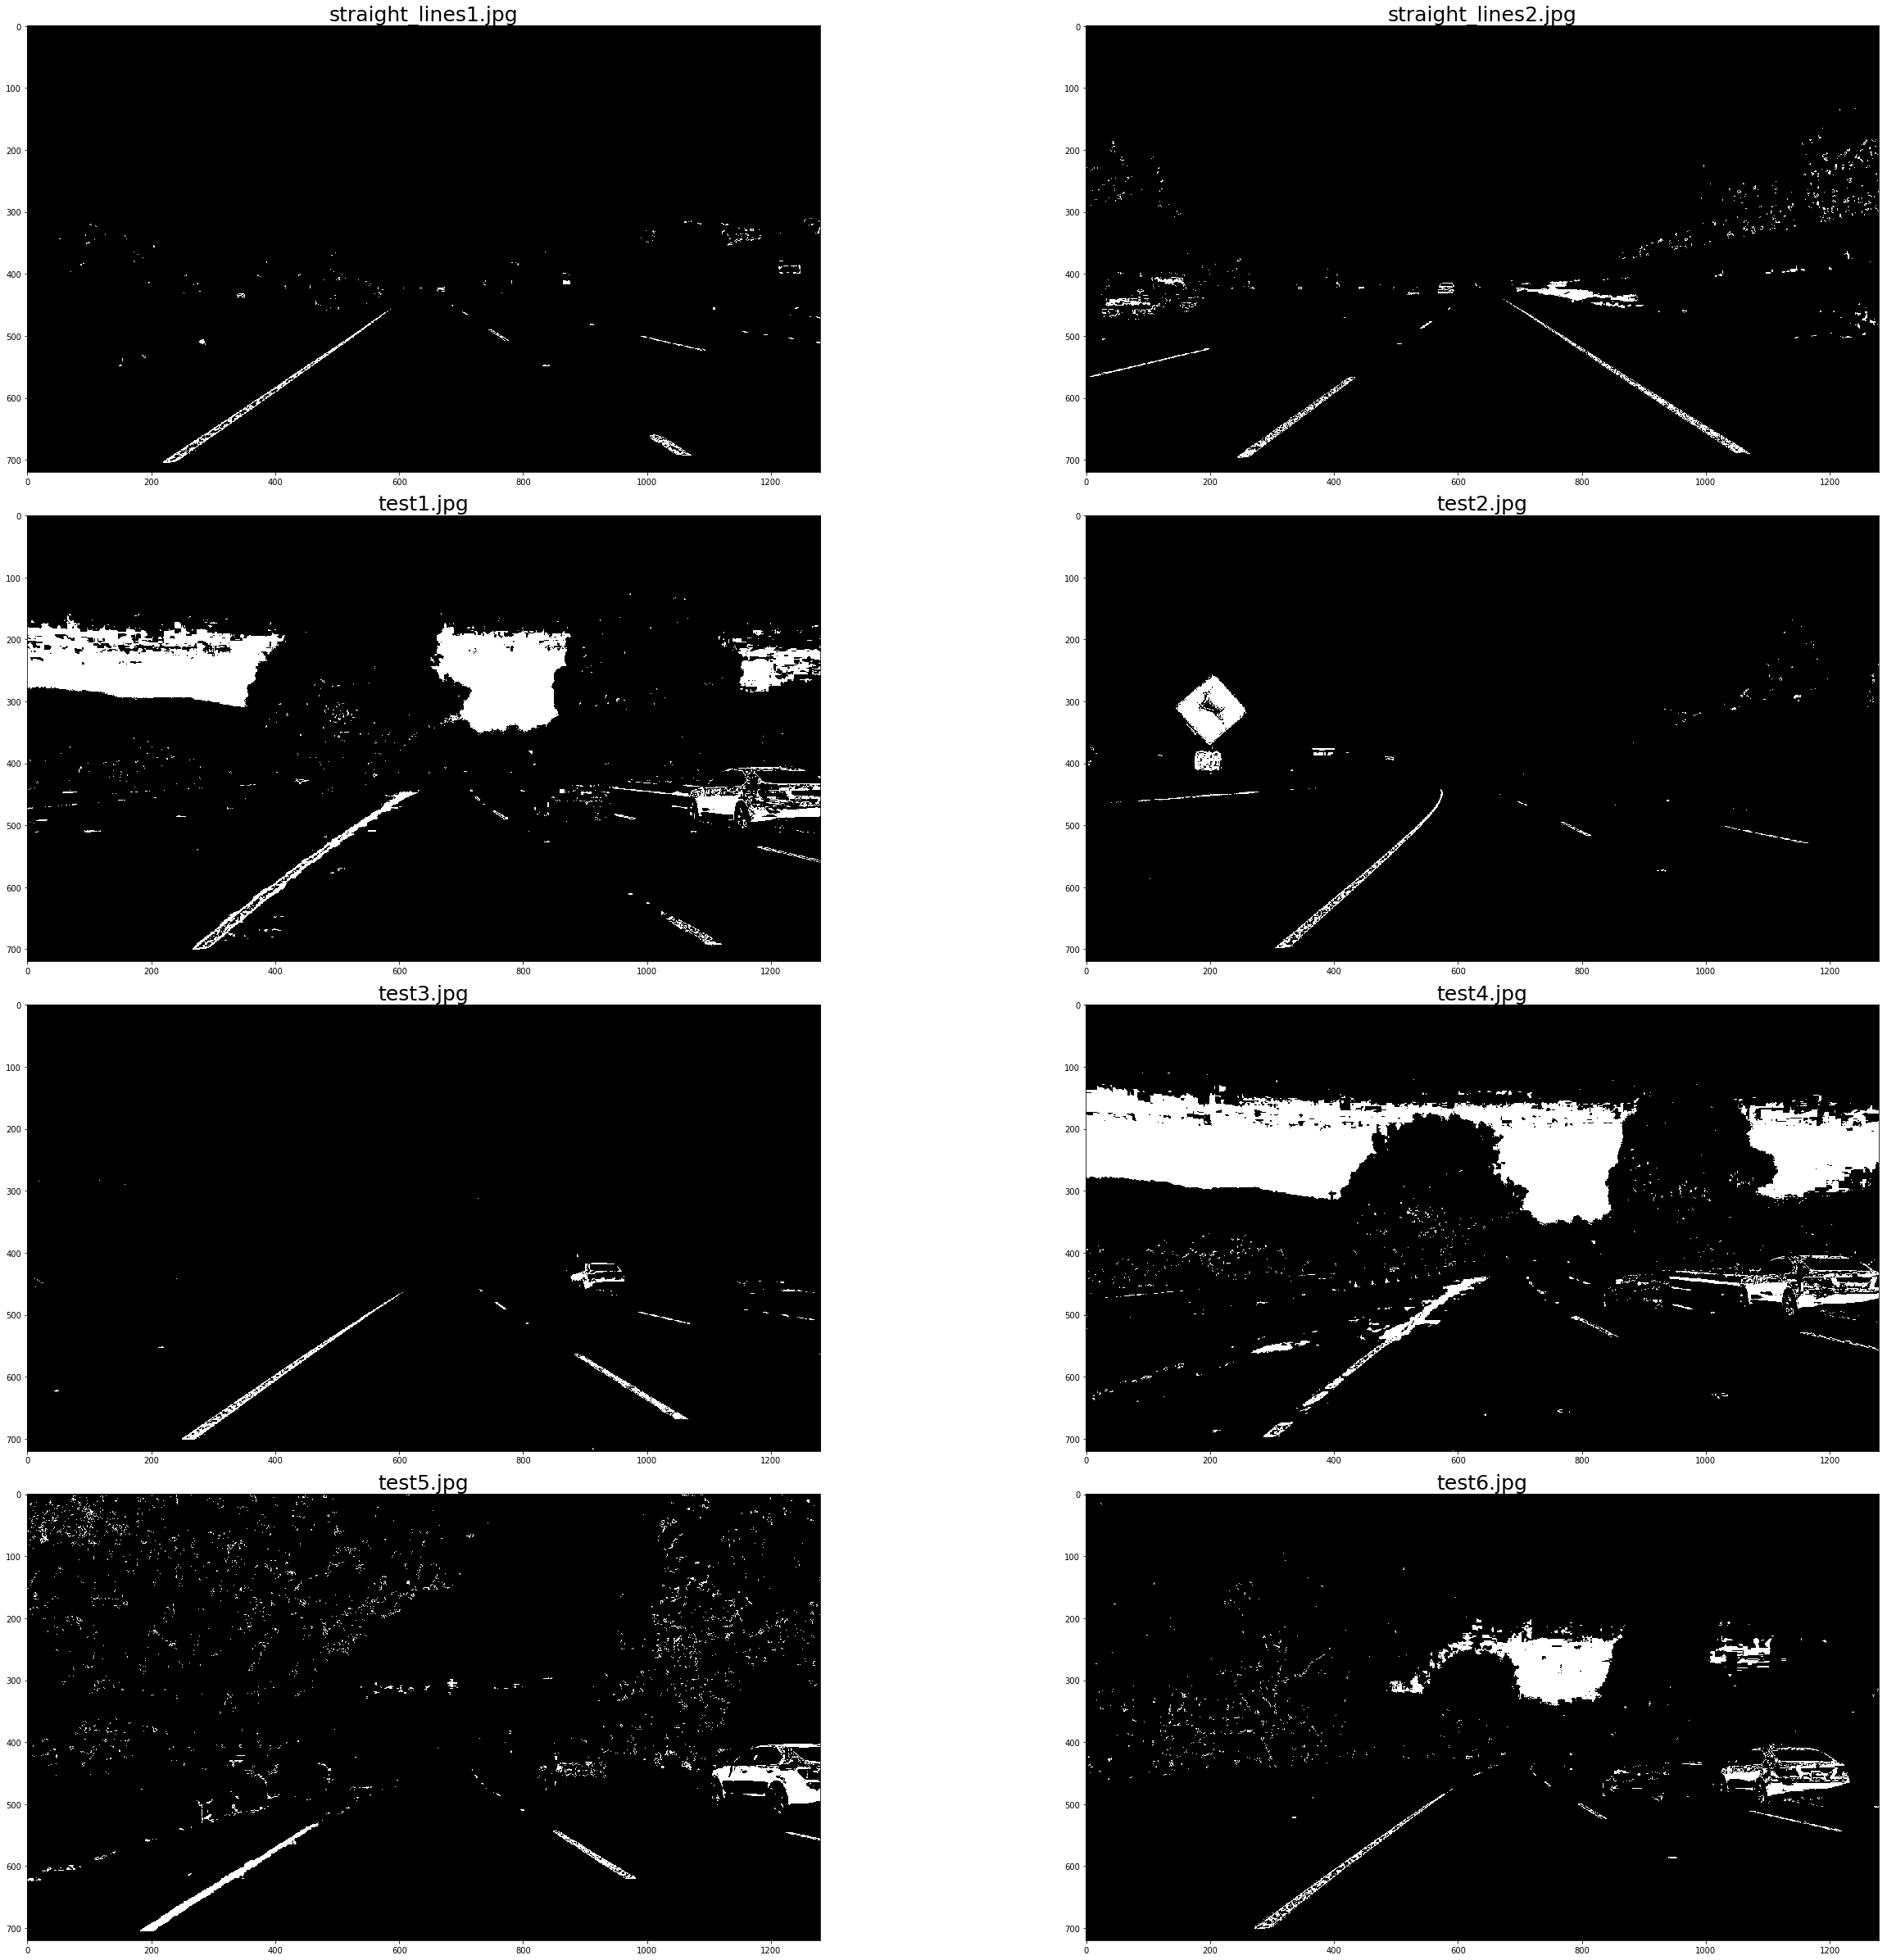

In [259]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
image_width = 80/row_len
image = None

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = color_transform(img)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# Test Gradient + Color Transform together

In [321]:
def gradient_plus_color_transform(img):
    ''' Converts an RGB image to a bimary lane line image using gradients + color space transforms
    '''
    grad = gradient_sobel(img)
    color = color_transform(img)
    
    img = np.zeros_like(color)
    img[(grad == 1) | (color == 1)] = 255 # At the end of the pipeline, create an image that's 0-255 scaled
    return img

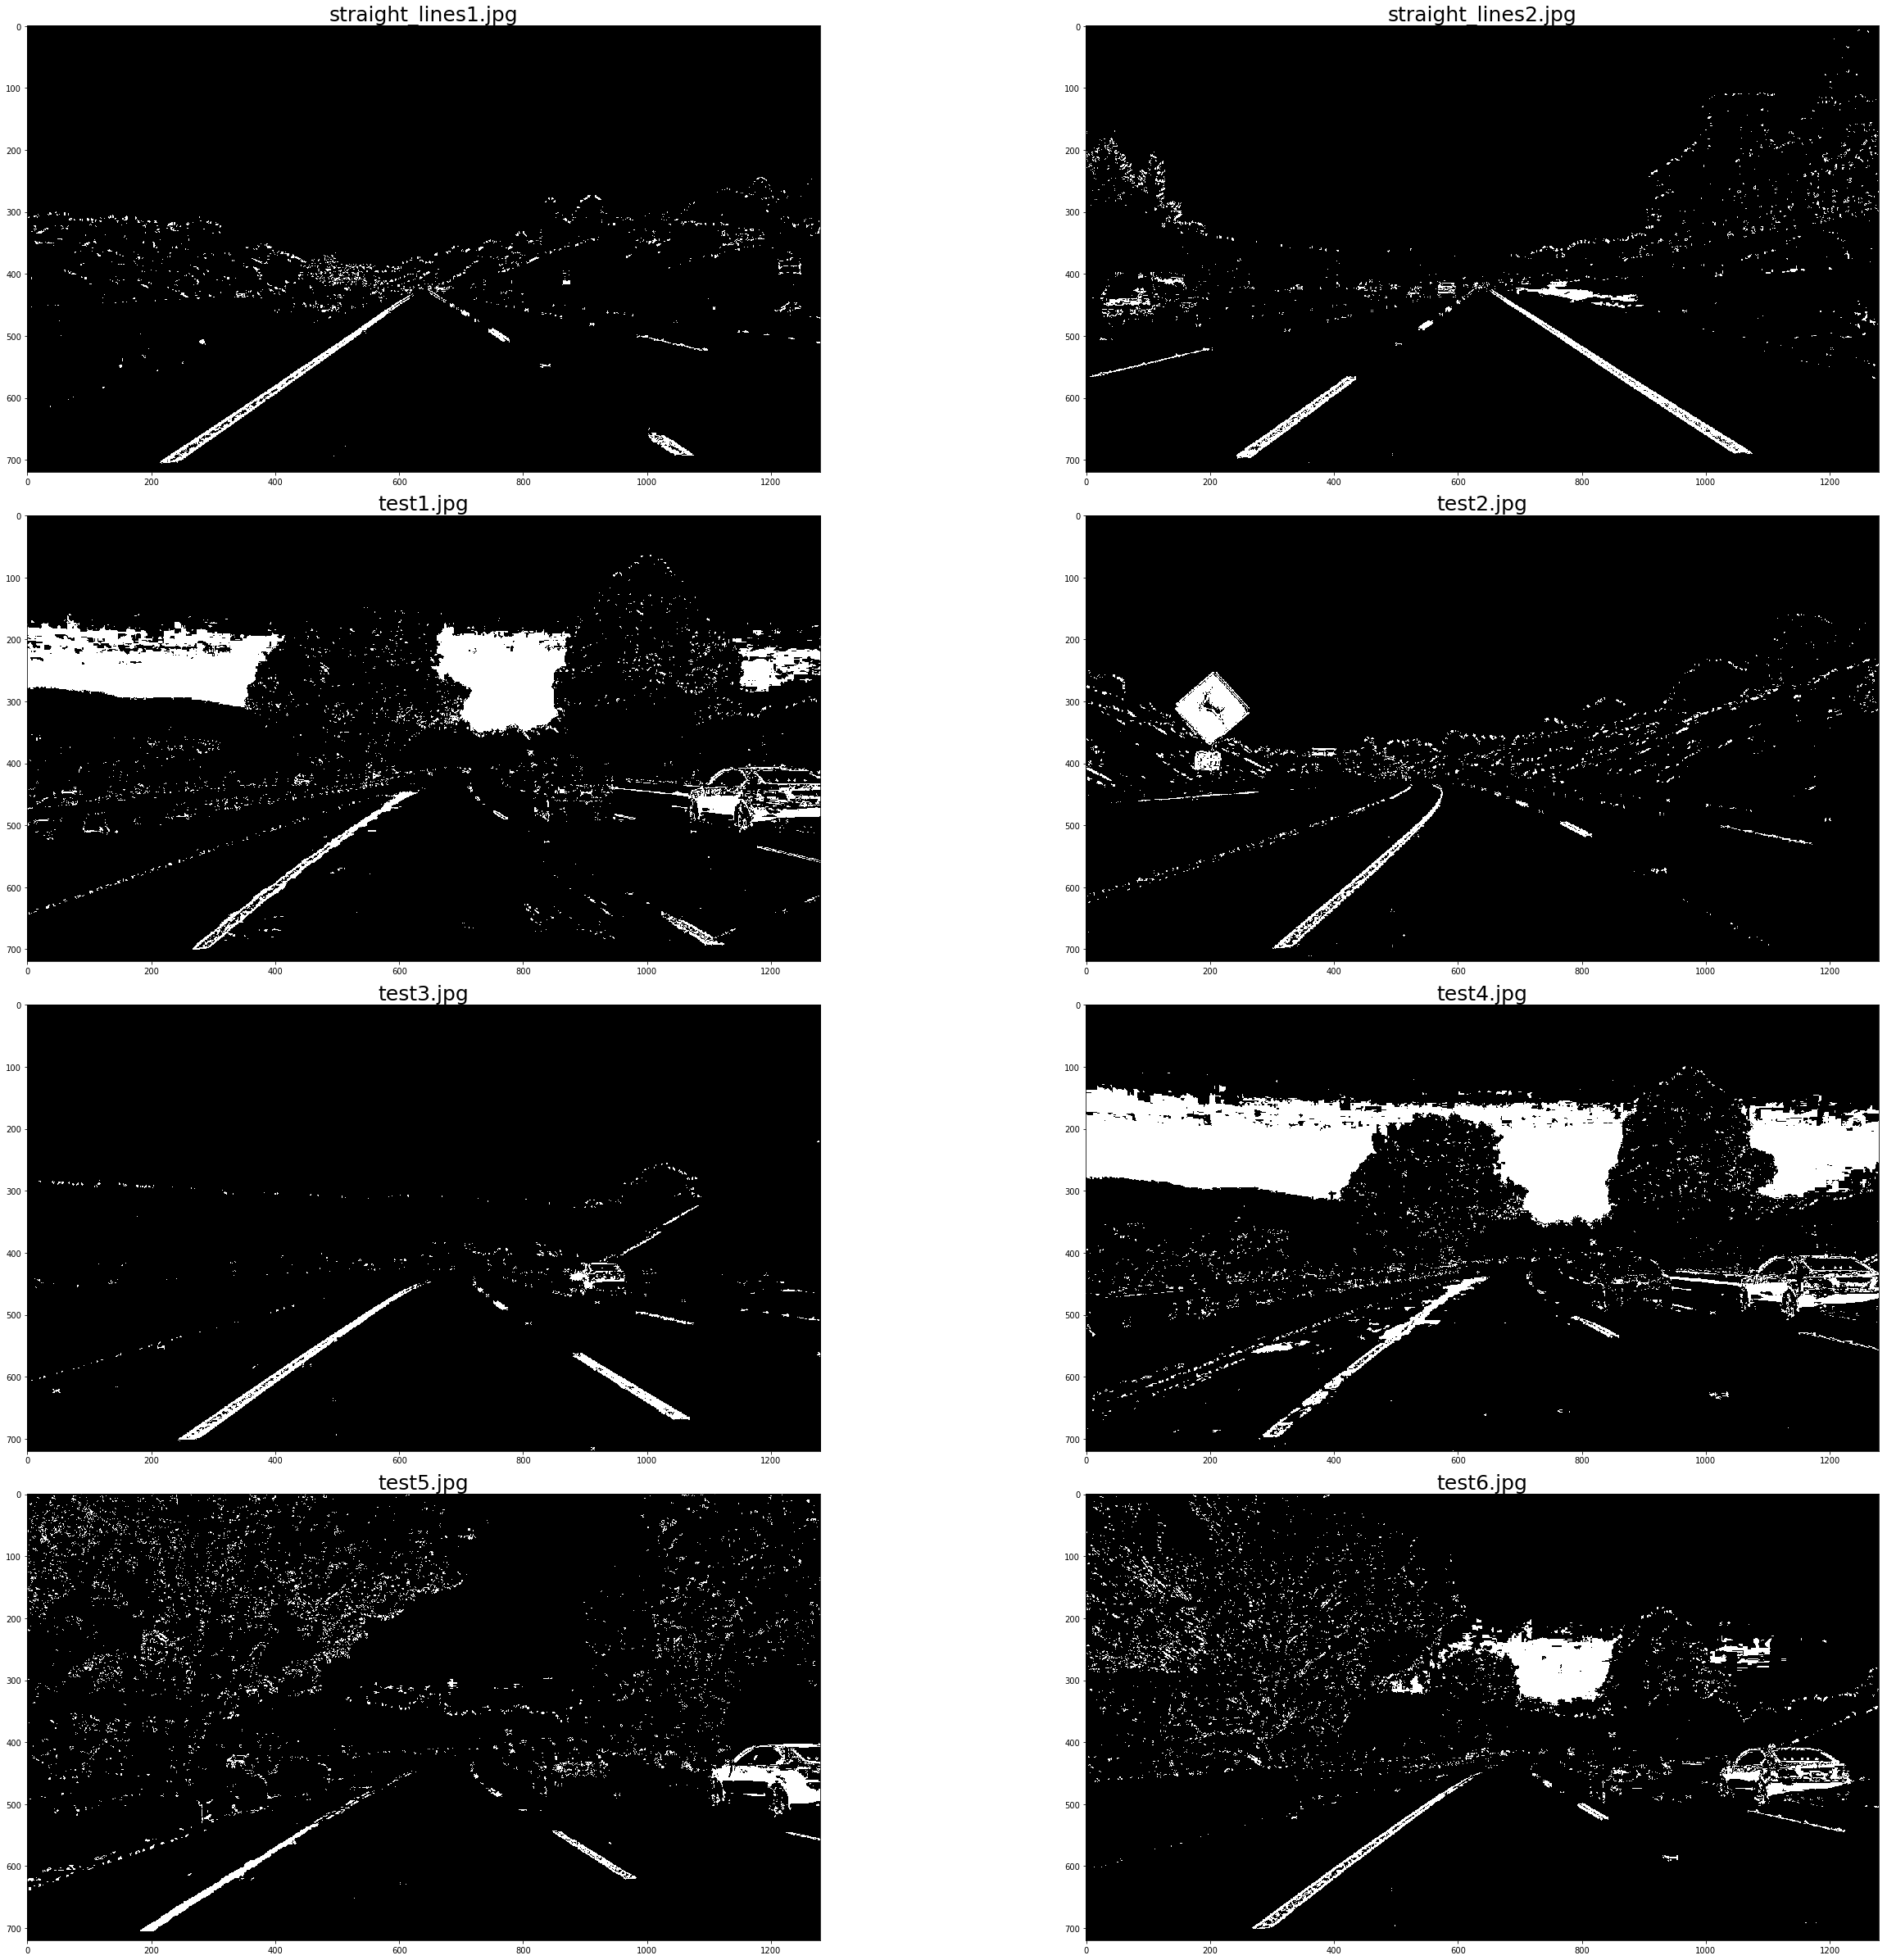

In [322]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
image_width = 80/row_len
image = None

fig, axes = plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = gradient_plus_color_transform(img)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# Perspective Transform

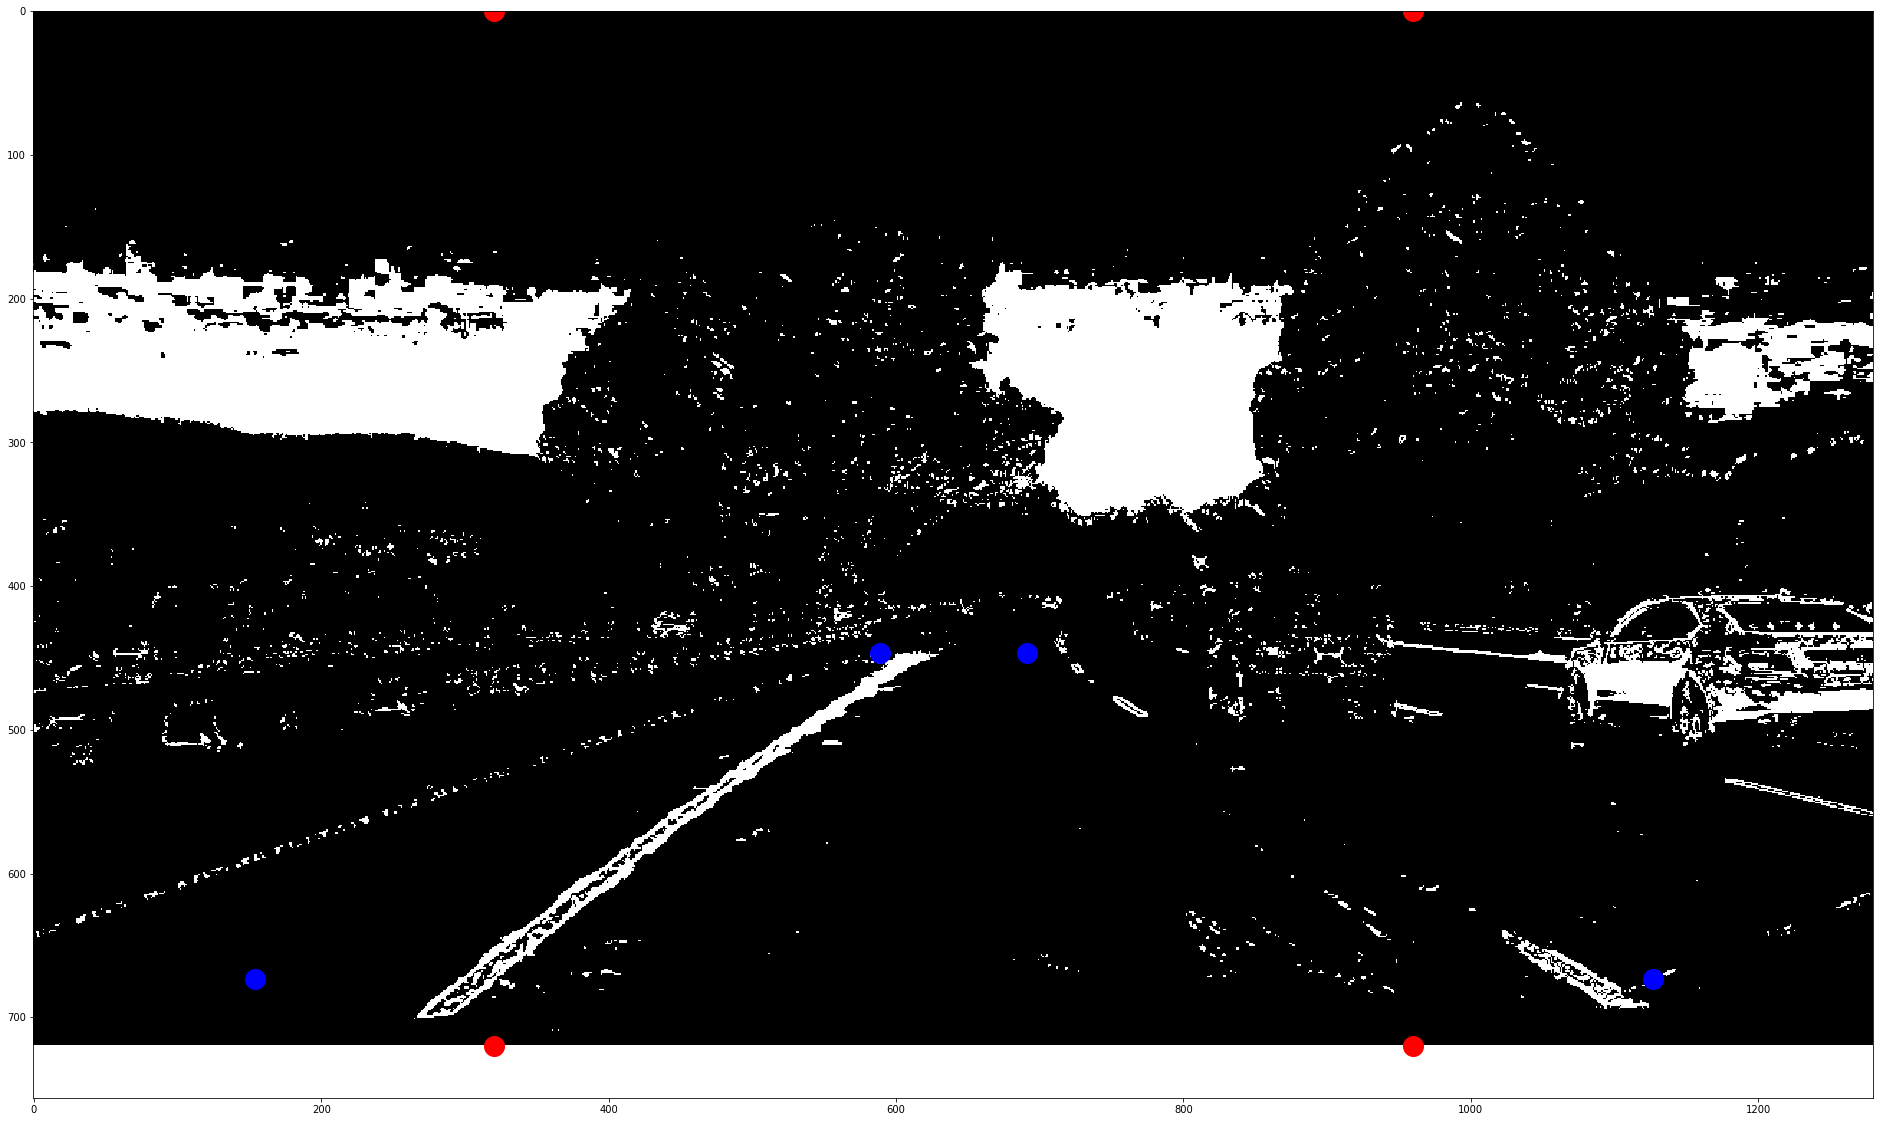

In [323]:
img = mpimg.imread('./test_images/test1.jpg')
# img = mpimg.imread('./test_images/test_lanes.png')
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
img = calibrate_image(img)
img = gradient_plus_color_transform(img)
w,h = img.shape[::-1] # Width x Height instead of Height x Width

fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(img, cmap='gray') 

# img_size = (img.shape[1], img.shape[0])
# h = img_size[0]
# w = img_size[1]

offset = w*.25
dst = np.float32(
[[w*.25,0], # Top left
[w*.75, 0], # Top right
[w*.25, h], # Bottom left
[w*.75, h]]) # Bottom right

## Stealing from youtube...
mid_width = 0.08
bot_width = 0.76
height_pct = .62
bottom_trim = 0.935

top_left =  (w*(0.5-mid_width/2), h*height_pct)
top_right = (w*(0.5+mid_width/2), h*height_pct)
bottom_left =  (w*(0.5-bot_width/2), h*bottom_trim)
bottom_right = (w*(0.5+bot_width/2), h*bottom_trim)

src = np.float32([top_left, top_right, bottom_left, bottom_right])
for pt in src:
    plt.plot(*pt,'bo',markersize=20)
    
for pt in dst:
    plt.plot(*pt,'ro',markersize=20)

In [262]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# img_size = img.shape[::-1]
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
# fig, ax = plt.subplots(figsize=(40, 20))
# ax.imshow(warped, cmap='gray') 

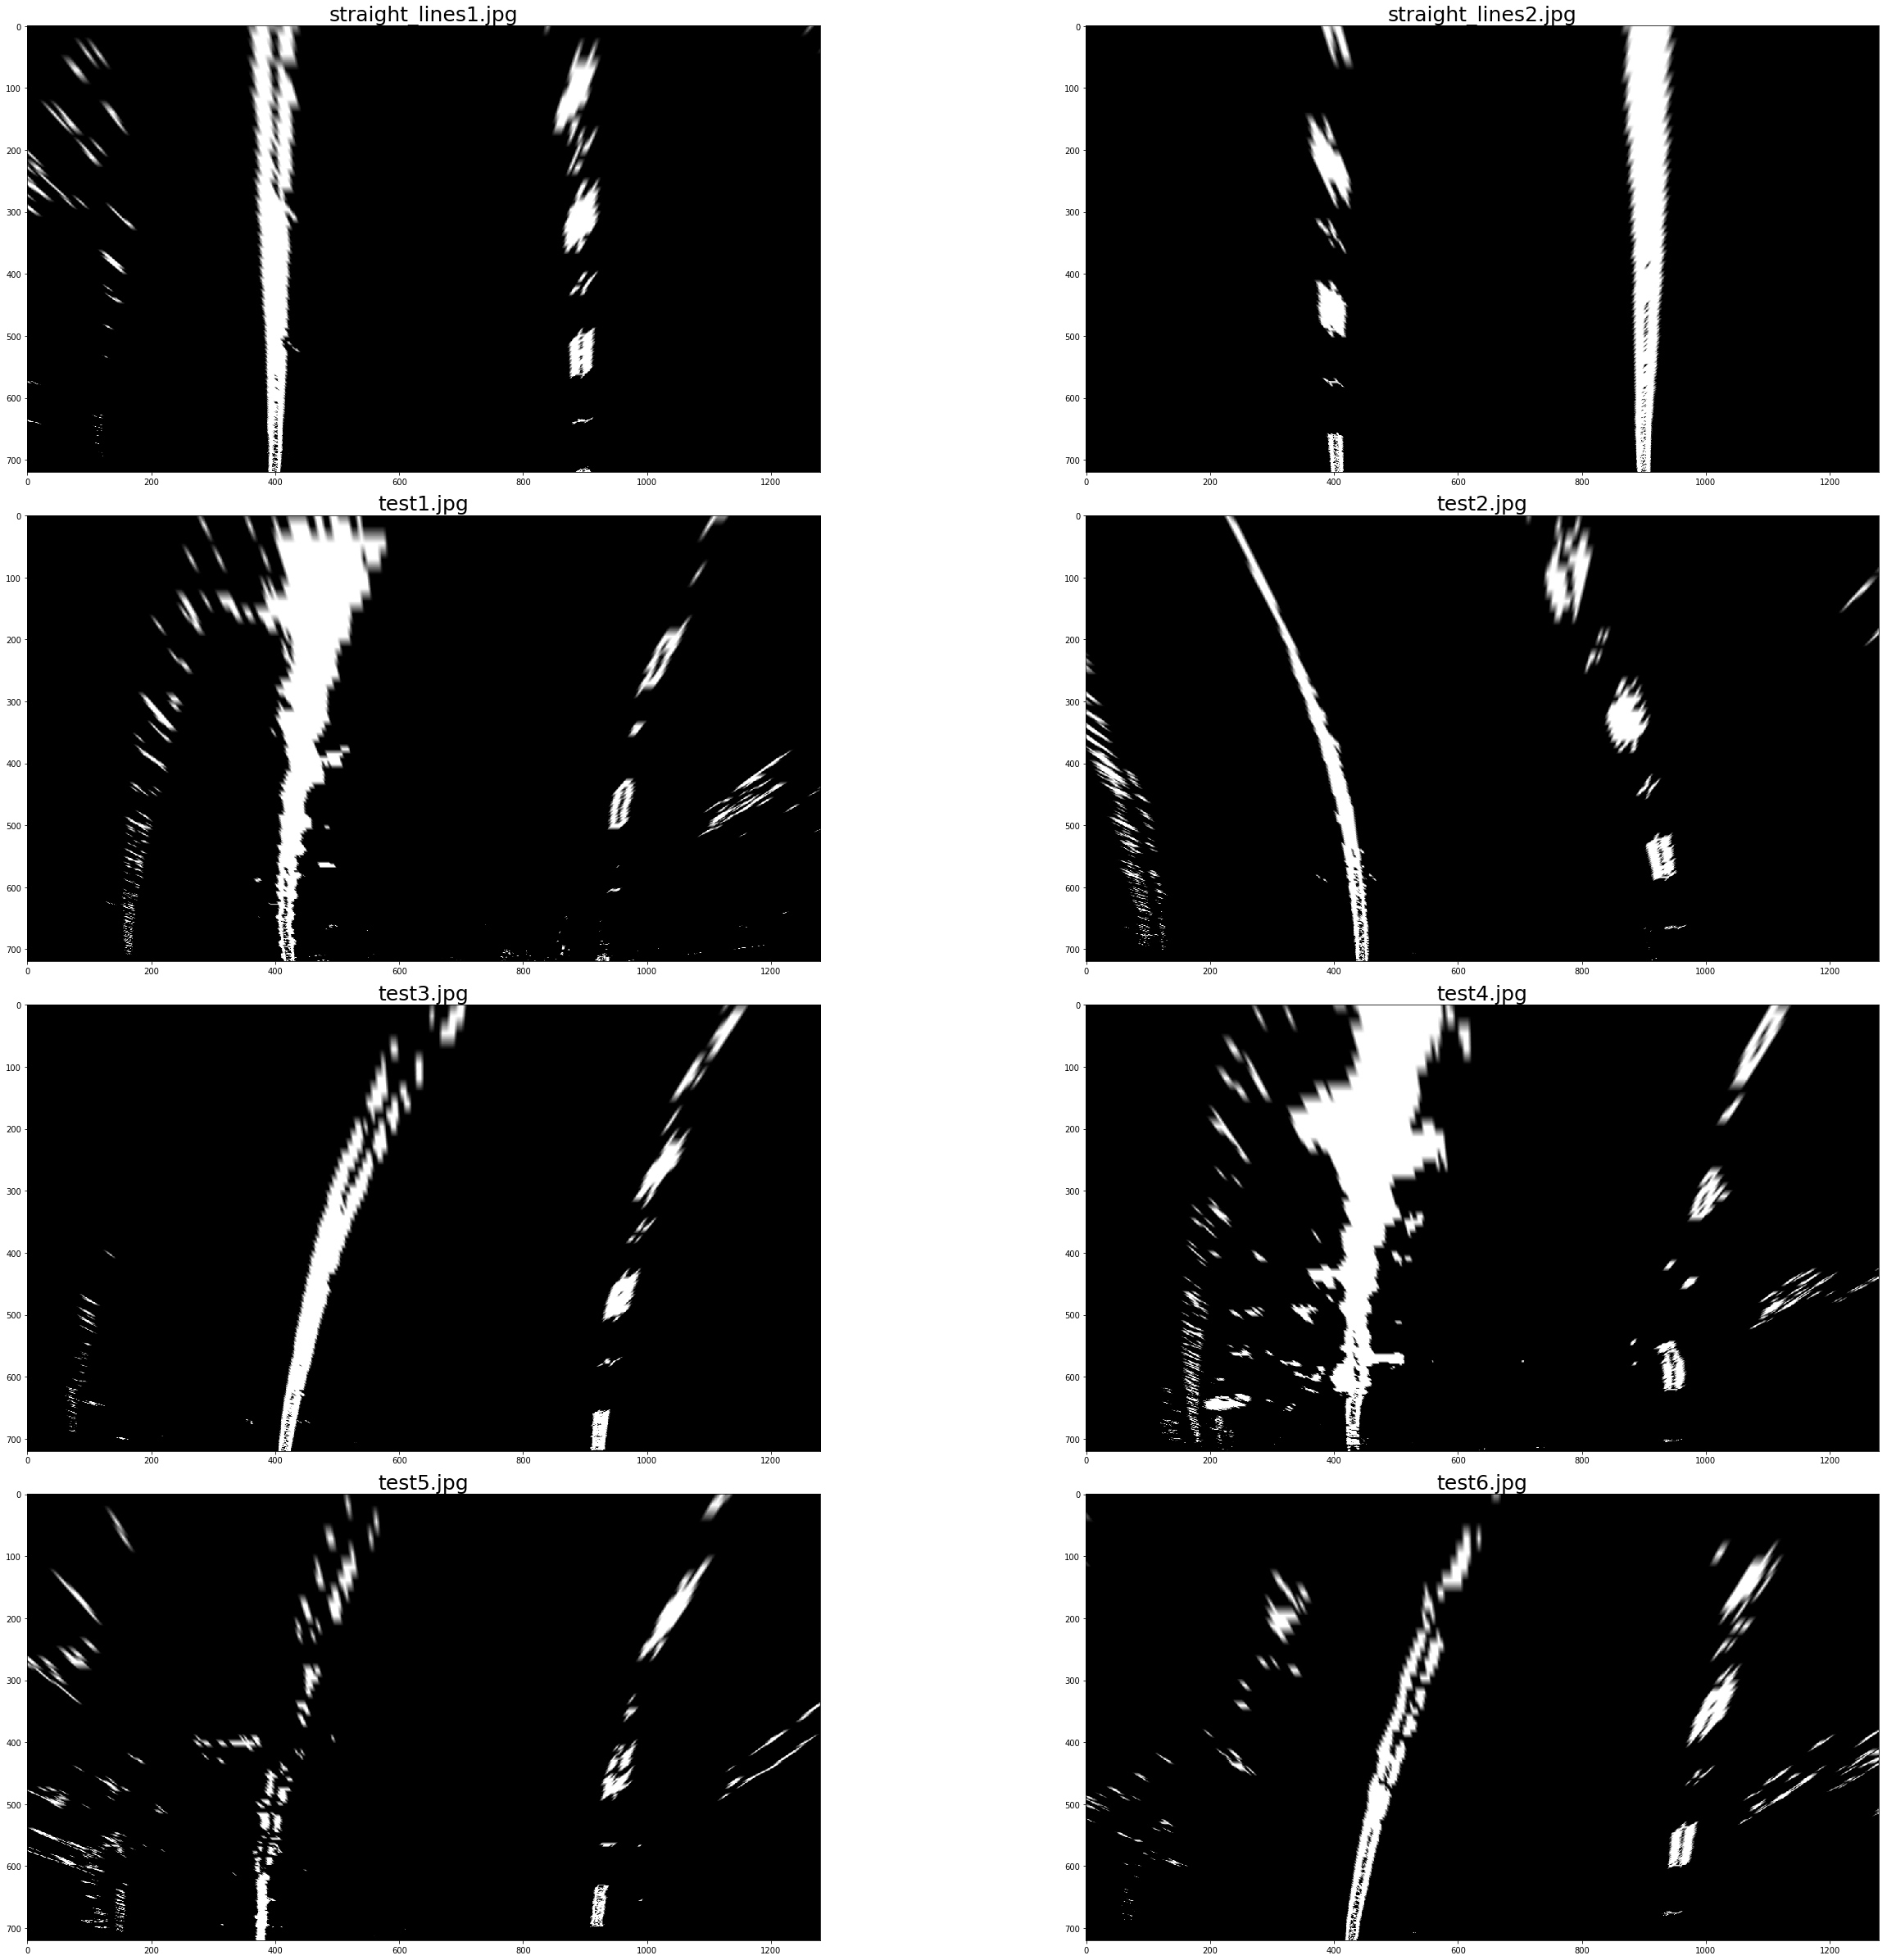

In [324]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
plot_width = 80/row_len
plot_height = plot_width/1.2
img_size = img.shape[::-1]
image = None

fig, axes = plt.subplots(n_images//row_len, row_len, figsize=(plot_width,plot_height))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = gradient_plus_color_transform(img)
    img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# Line Tracker

In [287]:
class Tracker():
    def __init__(self, window_width, window_height, margin, ym=1, xm=1, smooth_factor=15):
        self.recent_centers = []
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.ym_per_px = ym # meters per pixel
        self.xm_per_px = xm 
        self.smooth_factor = smooth_factor
    
    def find_window_centroids(self, warped):
        window_centroids = []
        window = np.ones(self.window_width)
        h,w = warped.shape
        
        l_sum = np.sum(warped[3*h//4:,:w//2], axis=0) # squash bottom of pic to 1D array
        l_center = np.argmax(np.convolve(window, l_sum)) - self.window_width/2 # find largest area using convolution
        r_sum = np.sum(warped[3*h//4:,w//2:], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - self.window_width/2 + w//2
        
        window_centroids.append((l_center, r_center))
        
        for level in range(1, h//self.window_height):
            image_layer = np.sum(warped[h-(level+1)*self.window_height:h-level*self.window_height,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            offset = self.window_width/2
            l_min_index = int(max(l_center+offset-self.margin, 0))
            l_max_index = int(min(l_center+offset+self.margin, warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            r_min_index = int(max(r_center+offset-self.margin, 0))
            r_max_index = int(min(r_center+offset+self.margin, warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            window_centroids.append((l_center, r_center))
            
        self.recent_centers.append(window_centroids)
        
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)

In [297]:
def window_mask(width, height, img_ref, center, level):
    ''' Creates a mask of 1's
    '''    
    h,w = img_ref.shape
    output = np.zeros_like(img_ref)
    output[int(h-(level+1)*height):int(h-level*height),max(0,int(center-width)):min(int(center+width),w)] = 1
    return output

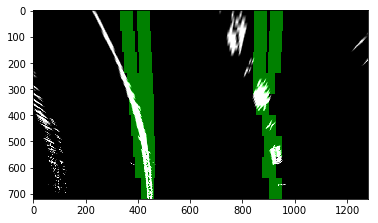

In [325]:
# For image in video...?
img = mpimg.imread('./test_images/test2.jpg')
img = calibrate_image(img)
img = gradient_plus_color_transform(img)
warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
w,h = img.shape[::-1] # Width x Height instead of Height x Width

# fig, ax = plt.subplots(figsize=(40, 20))
# ax.imshow(img, cmap='gray') 

window_width=25
window_height=80

curve_centers = Tracker(window_width=window_width, window_height=window_width, margin=25, 
                        ym=10/720, xm=4/384, smooth_factor=15)
window_centroids = curve_centers.find_window_centroids(warped)

l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

for level in range(0, len(window_centroids)):
    l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0],level)
    r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1],level)
    
    l_points [(l_points == 255) | ((l_mask == 1))] = 255
    r_points [(r_points == 255) | ((r_mask == 1))] = 255
    
template = np.array(r_points+l_points, np.uint8) # merge left and right window pixels
zero_channel = np.zeros_like(template) 
template = np.array(cv2.merge((zero_channel,template,zero_channel)), np.uint8)
warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
# result = warped
plt.imshow(result)

KeyboardInterrupt: 

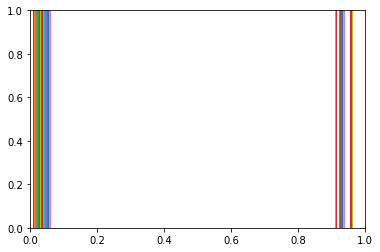

In [320]:
# warpage[0]
# plt.hist(warped)